# Calibration of a diffraction setup using `Jupyter` notebooks

This notebook presents a very simple GUI for doing the calibration of diffraction setup within the `Jupyter` lab or notebook environment with `Matplotlib` and `Ipywidgets`. 
It has been tested with `widget` and the `notebook` (aka `nbagg`) integration of matplotlib.

Despite this is in the `cookbook` section, this **tutorial** requires advanced Python programming knowledge and some good understanding of `PyFAI`.

This tutorial is also available as a video:

In [1]:
#Video of this tutorial
from IPython.display import Video

Video("http://www.silx.org/pub/pyFAI/video/Calibration_Jupyter.mp4", width=800)

The basic idea is to port directly the original `pyFAI-calib` tool which was done with `matplotlib` into the Jupyter notebooks. Most credits go **Philipp Hans** for the adaptation of the origin PeakPicker class to Jupyter.

The PeakPicker widget has been refactored and the Calibration tool adapted for the notebook usage.
Several external tools were used with the following version:

In [2]:
for lib in ["jupyterlab", "notebook", "matplotlib", "ipympl", "ipywidgets"]:
    mod = __import__(lib)
    print(f"{lib:12s}:   {mod.__version__}")

jupyterlab  :   4.0.0a15
notebook    :   6.5.2
matplotlib  :   3.6.2
ipympl      :   0.9.2
ipywidgets  :   8.0.4


In [3]:
#%matplotlib nbagg 
# The notebook interface (nbagg) is needed in jupyter-notebook while the widget is recommended for jupyer lab
%matplotlib widget

import pyFAI
import pyFAI.test.utilstest
import fabio
from matplotlib.pyplot import subplots
from pyFAI.gui import jupyter
from pyFAI.gui.jupyter.calib import Calibration

print(f"PyFAI version {pyFAI.version}")

matplotlib already loaded, setting its backend may not work
Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Degrading method from Method(dim=1, split='pseudo', algo='histogram', impl='*', target=None) -> Method(dim=1, split='bbox', algo='histogram', impl='*', target=None)


PyFAI version 2023.1.0-dev0


In [4]:
# Some parameters like the wavelength, the calibrant and the diffraction image:
wavelength = 1e-10
pilatus = pyFAI.detector_factory("Pilatus1M")
AgBh = pyFAI.calibrant.CALIBRANT_FACTORY("AgBh")
AgBh.wavelength = wavelength

#load some test data (requires an internet connection)
img = fabio.open(pyFAI.test.utilstest.UtilsTest.getimage("Pilatus1M.edf")).data

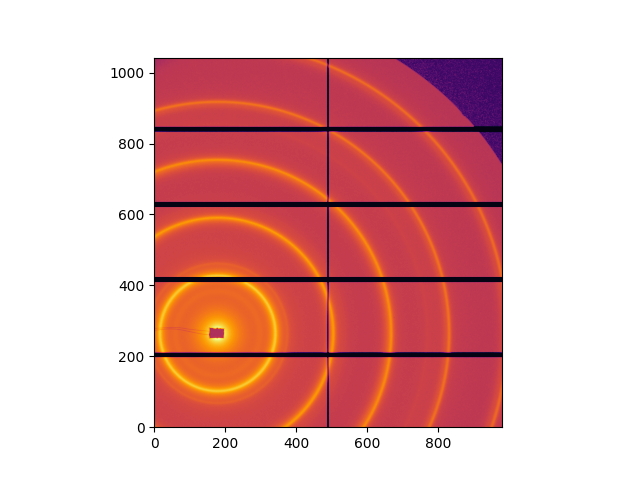

In [5]:
# Simply display the scattering image:
_ = jupyter.display(img)

In [6]:
calib = Calibration(img, calibrant=AgBh, wavelength=wavelength, detector=pilatus)
# This displays the calibration widget: 

# 1. Set the ring number (0-based value), below the plot 
# 2. Pick the ring by right-clicking with the mouse on the image.
# 3. Restart at 1. for at least a second ring
# 4. Click refine to launch the calibration.

Image size is (1043, 981)
Binning size is [1, 1]


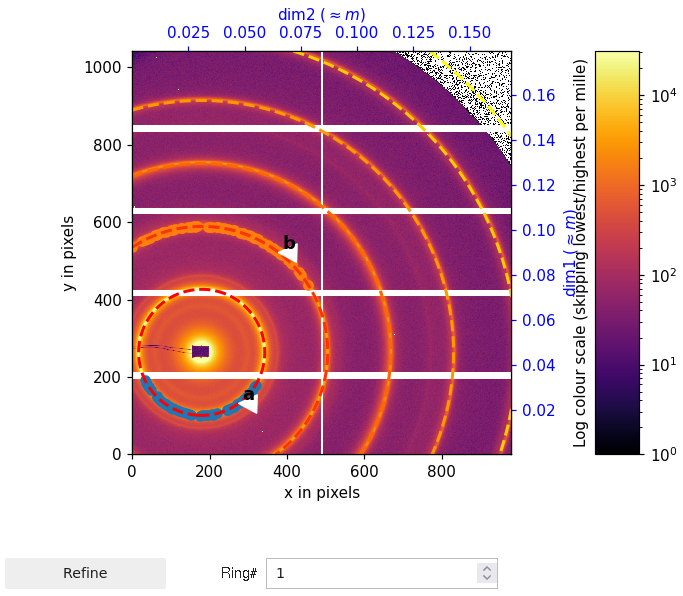

In [7]:
# Here is a screenshot of the previous widget, since it is not recoreded inside the notebook itself.
from IPython.display import Image
Image(filename='pyFAI-calib_notebook.png') 

In [8]:
# This is the calibrated geometry:
gr = calib.geoRef
print(gr)
print(f"Fixed parameters: {calib.fixed}")
print(f"Cost function: {gr.chi2()}")

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.000000e-10 m
SampleDetDist= 1.629600e+00 m	PONI= 1.376041e-01, 9.886305e-02 m	rot1=0.041635  rot2=-0.056420  rot3=0.000000 rad
DirectBeamDist= 1633.613 mm	Center: x=180.086, y=264.443 pix	Tilt= 4.017° tiltPlanRotation= -126.389° 𝛌= 1.000Å
Fixed parameters: ['wavelength', 'rot3']
Cost function: 6.848262305203506e-08


In [9]:
# re-extract all control points using the "massif" algorithm 
calib.extract_cpt()

in extract_cpt with method massif
Extracting datapoint for ring 0 (2theta = 0.98 deg); searching for 314 pts out of 7247 with I>8683.6, dmin=1.3
Extracting datapoint for ring 1 (2theta = 1.96 deg); searching for 166 pts out of 7736 with I>1455.7, dmin=2.5
Extracting datapoint for ring 2 (2theta = 2.94 deg); searching for 141 pts out of 9721 with I>862.1, dmin=3.8
Extracting datapoint for ring 3 (2theta = 3.93 deg); searching for 126 pts out of 11303 with I>320.5, dmin=5.1
Extracting datapoint for ring 4 (2theta = 4.91 deg); searching for 71 pts out of 8025 with I>230.9, dmin=5.9
Extracting datapoint for ring 5 (2theta = 5.89 deg); searching for 18 pts out of 6358 with I>0.9, dmin=1.5


In [10]:
# remove the last ring since it is outside the flight-tube
calib.remove_grp(lbl="f")

In [11]:
#Those are all control points: the last column indicates the ring number
calib.geoRef.data

array([[222.88795992, 336.24218315,   0.        ],
       [426.02423096, 171.99751282,   0.        ],
       [104.04784393, 212.98831177,   0.        ],
       ...,
       [576.84797493, 933.19860423,   4.        ],
       [ 91.83321899, 977.03293057,   4.        ],
       [108.        , 980.        ,   4.        ]])

In [12]:
# This is the geometry with all rings defined:
gr = calib.geoRef
print(gr)
print(f"Fixed parameters: {calib.fixed}")
print(f"Cost function: {gr.chi2()}")

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.000000e-10 m
SampleDetDist= 1.629600e+00 m	PONI= 1.376041e-01, 9.886305e-02 m	rot1=0.041635  rot2=-0.056420  rot3=0.000000 rad
DirectBeamDist= 1633.613 mm	Center: x=180.086, y=264.443 pix	Tilt= 4.017° tiltPlanRotation= -126.389° 𝛌= 1.000Å
Fixed parameters: ['wavelength', 'rot3']
Cost function: 1.3601435896262711e-05


In [13]:
# Geometry refinement with some constrains: SAXS mode 
# Here we enforce all rotation to be null and fit again the model:

gr.rot1 = gr.rot2 = gr.rot3 = 0
gr.refine3(fix=["rot1", "rot2", "rot3", "wavelength"])
print(gr)
print(f"Cost function = {gr.chi2()}")

Constrained Least square 0.0017210140636997181 --> 1.3233245733493102e-09
maxdelta on poni1: 0.13760408540096405 --> 0.04542296244189746 


Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.699969122650443e-07
            Iterations: 13
            Function evaluations: 58
            Gradient evaluations: 13
Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.000000e-10 m
SampleDetDist= 1.634983e+00 m	PONI= 4.542296e-02, 3.093510e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 1634.983 mm	Center: x=179.855, y=264.087 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å
Cost function = 9.699969122650443e-07


In [14]:
gr.save("jupyter.poni")
gr.get_config()

OrderedDict([('poni_version', 2),
             ('detector', 'Pilatus1M'),
             ('detector_config', OrderedDict()),
             ('dist', 1.6349833746167908),
             ('poni1', 0.04542296244189746),
             ('poni2', 0.0309351019501416),
             ('rot1', 0.0),
             ('rot2', 0.0),
             ('rot3', 0.0),
             ('wavelength', 1e-10)])

In [15]:
# Create a "normal" azimuthal integrator (without fitting capabilities from the geometry-refinement object)
ai = pyFAI.load(gr)
ai

Unable to parse Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.000000e-10 m
SampleDetDist= 1.634983e+00 m	PONI= 4.542296e-02, 3.093510e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 1634.983 mm	Center: x=179.855, y=264.087 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å as JSON file, defaulting to PoniParser


Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.000000e-10 m
SampleDetDist= 1.634983e+00 m	PONI= 4.542296e-02, 3.093510e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 1634.983 mm	Center: x=179.855, y=264.087 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å

AI.integrate1d_ng: Resetting Cython integrator because of first initialization


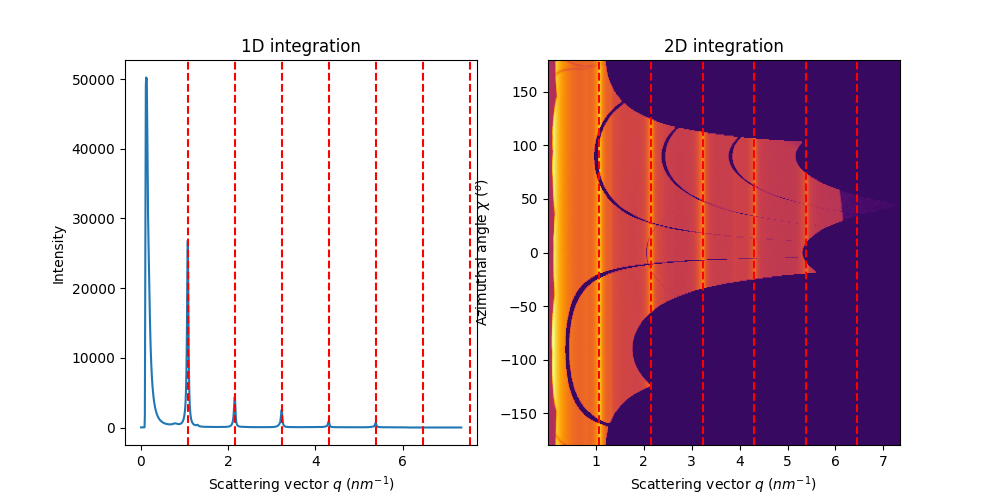

In [16]:
# Display the integrated data to validate the calibration.
fig, ax = subplots(1, 2, figsize=(10, 5))
jupyter.plot1d(ai.integrate1d(img, 1000),  calibrant=AgBh, ax=ax[0])
jupyter.plot2d(ai.integrate2d(img, 1000),  calibrant=AgBh, ax=ax[1])
_ = ax[1].set_title("2D integration")

## Conclusion

This short notebook shows how to interact with a calibration image to pick some control-point from the Debye-Scherrer ring and to perform the calibration of the experimental setup.